In [2]:
import os

import numpy as np
import pandas as pd
from sqlalchemy import create_engine, URL

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

import itertools
import statsmodels.api as sm

import warnings

In [3]:
db_url = URL.create(
    drivername="postgresql",
    username=os.environ["DB_USER"],
    password=os.environ["DB_PASSWORD"],
    host=os.environ["DB_HOST"],
    port=os.environ["DB_PORT"],
    database=os.environ["DB_NAME"],
)

db = create_engine(db_url)

In [4]:
weekly_df = pd.read_sql("SELECT * FROM glb_wk_time_series", db)

weekly_df = weekly_df.sort_values("week").reset_index(drop=True)

weekly_df["week"] = pd.to_datetime(weekly_df.week, format="%Y-%m-%d")

weekly_df = weekly_df[:-1]

In [5]:
weekly_df

,incident_count,week
0,31,2017-01-02
1,62,2017-01-09
2,30,2017-01-16
3,38,2017-01-23
4,29,2017-01-30
...,...,...
342,29,2023-07-24
343,37,2023-07-31
344,30,2023-08-07
345,39,2023-08-14


In [8]:
weekly_df.set_index("week", inplace=True)
weekly_df = weekly_df.sort_index()

weekly_df

,incident_count
week,
2017-01-02,31
2017-01-09,62
2017-01-16,30
2017-01-23,38
2017-01-30,29
...,...
2023-07-24,29
2023-07-31,37
2023-08-07,30


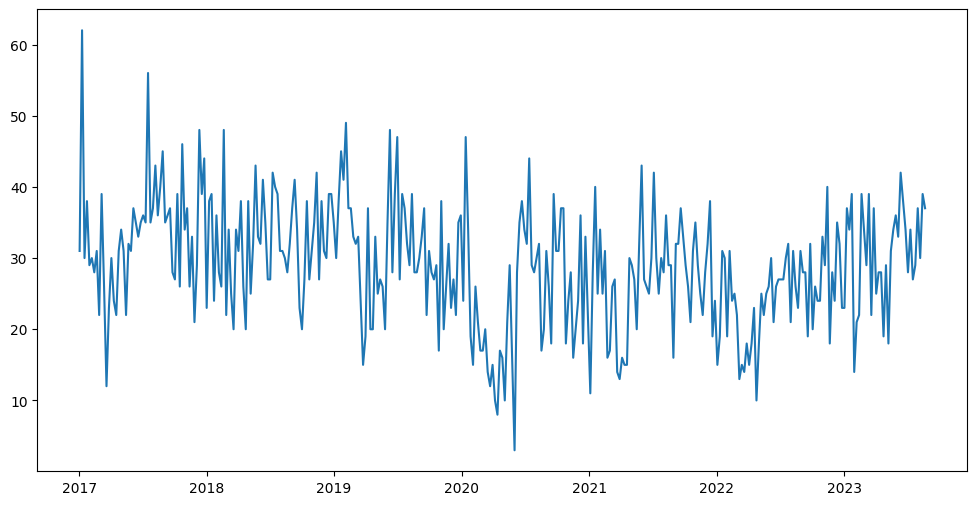

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['incident_count'])

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

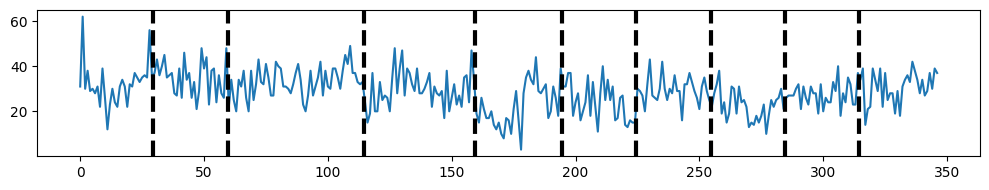

In [10]:
# DISCONTINUITY ANALYSIS
# https://forecastegy.com/posts/change-point-detection-time-series-python/
import ruptures as rpt

algo = rpt.Pelt(model="l2", min_size=28)
algo.fit(weekly_df)
result = algo.predict(pen=1)

rpt.display(weekly_df, [], result)


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

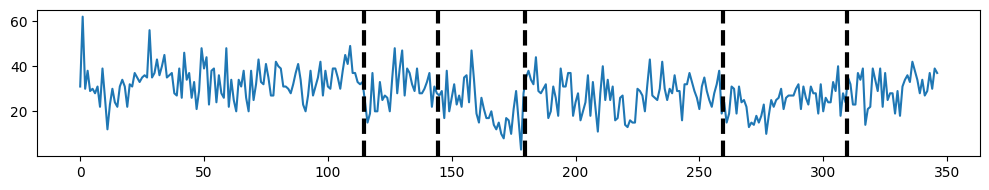

In [18]:
algo = rpt.Binseg(model="l2", min_size=28)
algo.fit(weekly_df)
result = algo.predict(n_bkps=5)

rpt.display(weekly_df, [], result)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

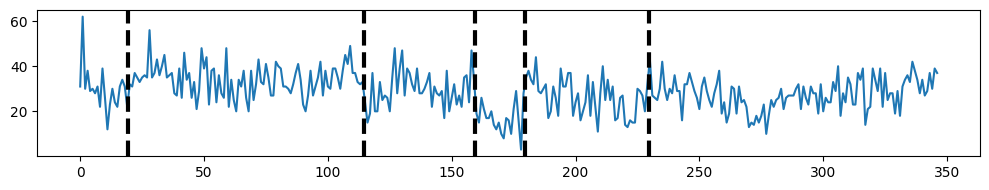

In [19]:
algo = rpt.Window(model="l2", width=28)
algo.fit(weekly_df)
result = algo.predict(n_bkps=5)

rpt.display(weekly_df, [], result)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

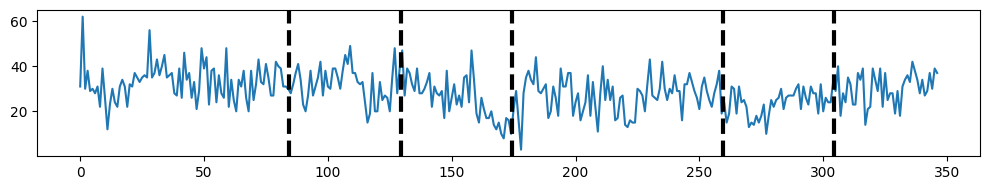

In [20]:
algo = rpt.BottomUp(model="l2", min_size=28)
algo.fit(weekly_df)
result = algo.predict(n_bkps=5)

rpt.display(weekly_df, [], result)

In [38]:
# https://github.com/sztistvan/change_detection/blob/main/change_point_detection_chatgpt.ipynb
import pandas as pd
import numpy as np

def detect_abrupt_changes_rolling(signal, percent_change, max_interval):
    # Calculate the minimum and maximum in the moving window
    rolling_mean = signal.rolling(window=max_interval, center=True).mean()
    rolling_std = signal.rolling(window=4*max_interval, center=True).std() # MODIFCATION

    # Calculate the threshold for the minimum change required to be considered an abrupt change.
    change_threshold = 2*rolling_std * percent_change


    # Calculate the difference between the local minimum and maximum
    diff = abs(signal - rolling_mean)

    # Calculate the percent change from the local minimum to the local maximum
    #percent_diff = diff / rolling_min * 100 # MODIFCATION
    
    change_points = [i for i in result if i < len(signal)]

    # Detect abrupt changes
    abrupt_changes = diff > change_threshold
    return [abrupt_changes, rolling_mean, rolling_std, change_points]

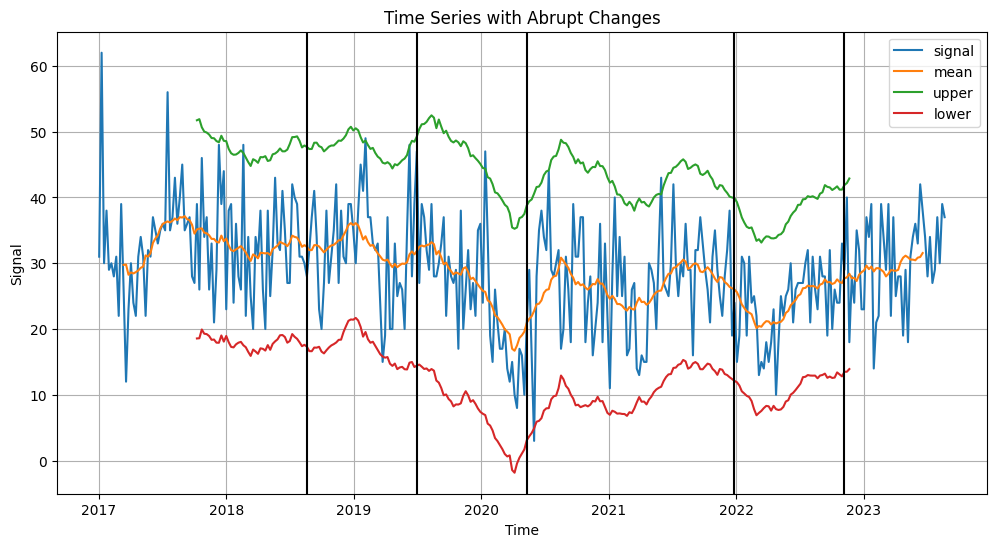

In [42]:
# Detect abrupt changes
abrupt_changes, rolling_mean, rolling_std, changes = detect_abrupt_changes_rolling(weekly_df, 1.2, 20)
abrupt_changes = abrupt_changes.astype(int)

# Plot the time series 
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_df, label='signal')
ax.plot(rolling_mean, label='mean')
ax.plot(rolling_mean+2*rolling_std, label='upper')
ax.plot(rolling_mean-2*rolling_std, label='lower')

for i in changes:
    ax.axvline(weekly_df.index[i], color='k')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

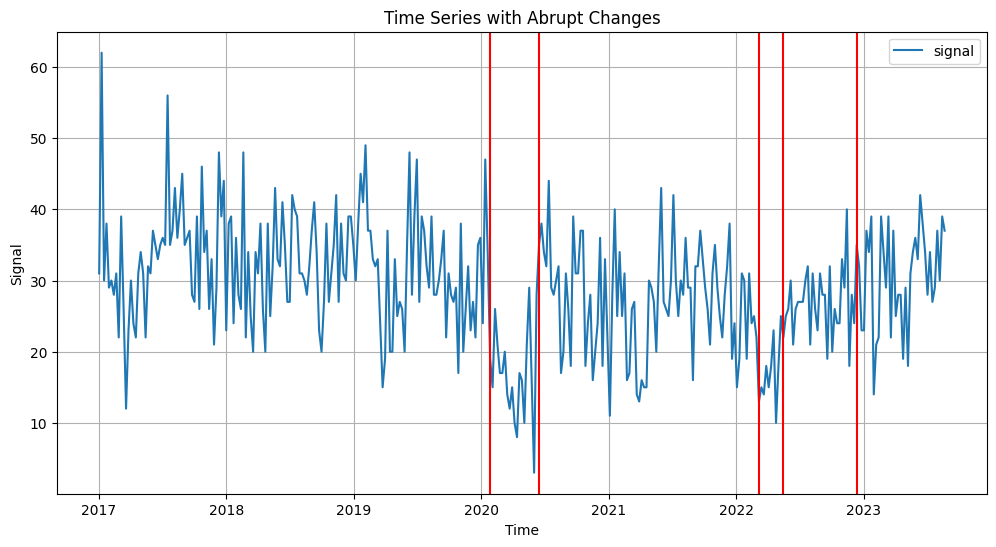

In [36]:
def detect_changes(time_series):
    # Convert time series to a numpy array
    signal = time_series.values

    # Perform change point detection using the Pelt algorithm
    algo = rpt.Pelt(model="rbf", min_size=1, jump=10).fit(signal)
    result = algo.predict(pen=2)

    # remove location if equal to len(signal)
    change_points = [i for i in result if i < len(signal)]

    # Return the list of change point locations
    return change_points

# Detect abrupt changes
changes = detect_changes(weekly_df)
#abrupt_changes = abrupt_changes.astype(int)

# Plot the time series 
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_df, label='signal')

# Plot the abrupt changes
for i in changes:
    ax.axvline(weekly_df.index[i], color='r')

# Add labels, grid, and legend
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Time Series with Abrupt Changes')
ax.legend()
ax.grid(True)

# Show the plot
plt.show()

### ARIMA

In [88]:
def arima_sensitivity(df, test_size):
    train_data = df[:-test_size]

    # Grid search for p, d, q
    p_values = range(0, 4)
    d_values = range(0, 2)
    q_values = range(0, 4)

    best_aic = float("inf")
    best_order = None

    warnings.filterwarnings("ignore")
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train_data['incident_count'], order=(p, d, q))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue

    print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")

In [89]:
arima_sensitivity(weekly_df, 1)

Best ARIMA Order: (3, 1, 1) with AIC: 2386.7593790396227


In [90]:
arima_sensitivity(weekly_df, 4)

Best ARIMA Order: (3, 1, 1) with AIC: 2366.7173796554252


In [91]:
def arima_model(df, test_size, p, d, q):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    
    model = ARIMA(train_data['incident_count'], order=(p, d, q))
    model_fit = model.fit()
    
    predictions = model_fit.forecast(steps=len(test_data))
    
    mse = mean_squared_error(test_data['incident_count'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse


In [92]:
arima_model(weekly_df, 1, 3, 1, 1)

4.204598794485001

In [93]:
arima_model(weekly_df, 4, 3, 1, 1)

7.686912378956735

### SARIMAX

In [ ]:
# R2

In [64]:
def sarimax_sensitivity(df, test_size, seasonality, p, d, q):
    train_data = df[:-test_size]
    
    # Grid search for P, D, Q
    P_values = range(0, 4)  # Replace with your preferred range
    D_values = range(0, 2)  # Replace with your preferred range
    Q_values = range(0, 4)  # Replace with your preferred range

    best_aic = float("inf")
    best_order = None

    for P, D, Q in itertools.product(P_values, D_values, Q_values):
        try:
            model = sm.tsa.SARIMAX(train_data['incident_count'], order=(p, d, q), seasonal_order=(P, D, Q, seasonality))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (P, D, Q)
        except:
            continue

    print(f"Best SARIMAX Seasonal Order: {best_order} with AIC: {best_aic}")

In [66]:
sarimax_sensitivity(weekly_df, 1, 4, 3, 1, 1)

In [68]:
sarimax_sensitivity(weekly_df, 4, 12, 3, 1, 1)

In [72]:
def sarimax_model(df, test_size):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    
    model = SARIMAX(train_data['incident_count'], order=(3, 1, 1), seasonal_order=(0, 0, 0, 0))
    model_fit = model.fit()
    
    predictions = model_fit.forecast(len(test_data))
    
    mse = mean_squared_error(test_data['incident_count'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse


In [73]:
sarimax_model(weekly_df, 1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45897D+00    |proj g|=  7.54615D-02

At iterate    5    f=  3.44903D+00    |proj g|=  4.35541D-02

At iterate   10    f=  3.43679D+00    |proj g|=  3.78930D-02

At iterate   15    f=  3.43367D+00    |proj g|=  1.18523D-03

At iterate   20    f=  3.43364D+00    |proj g|=  1.32651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   3.639D-06   3.434D+00
  F =   3.4336434143389138     

CONVERG

 This problem is unconstrained.


20.428346601792832

In [74]:
sarimax_model(weekly_df, 4)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46129D+00    |proj g|=  7.57550D-02

At iterate    5    f=  3.45148D+00    |proj g|=  4.20258D-02

At iterate   10    f=  3.43888D+00    |proj g|=  4.14850D-02

At iterate   15    f=  3.43553D+00    |proj g|=  1.40978D-03

At iterate   20    f=  3.43549D+00    |proj g|=  1.08258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     24      1     0     0   4.172D-06   3.435D+00
  F =   3.4354920848648640     

CONVERG

 This problem is unconstrained.


10.378101501234124

### SES

In [94]:
def ses_model(df, test_size):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    
    model = SimpleExpSmoothing(train_data['incident_count'])
    model_fit = model.fit()
    
    predictions = model_fit.forecast(steps=len(test_data))
    
    mse = mean_squared_error(test_data['incident_count'], predictions, squared=False)
    rmse = np.sqrt(mse)
    
    return rmse


In [95]:
ses_model(weekly_df, 1)

1.878705916180601

In [96]:
ses_model(weekly_df, 4)

2.401108861205192

### Plotting

In [103]:
def ses_run_and_plot(df, test_size):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    
    model = SimpleExpSmoothing(train_data['incident_count'])
    model_fit = model.fit()
    
    predictions = model_fit.forecast(steps=len(test_data))
    
    print(predictions)
    
    # Plot the training data
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['week'], train_data['incident_count'], label='Training Data', color='blue')

    # Plot the test data (actual trend)
    plt.plot(test_data['week'], test_data['incident_count'], label='Actual Trend', color='green')

    # Plot the SES predictions
    plt.plot(test_data['week'], predictions, label='SES Predictions', color='red')

    # Set labels and title
    plt.xlabel('Week')
    plt.ylabel('Incident Count')
    plt.legend()
    plt.title('SES Forecasting Results')

    # Show the plot
    plt.grid(True)
    plt.show()

346    33.470464
dtype: float64


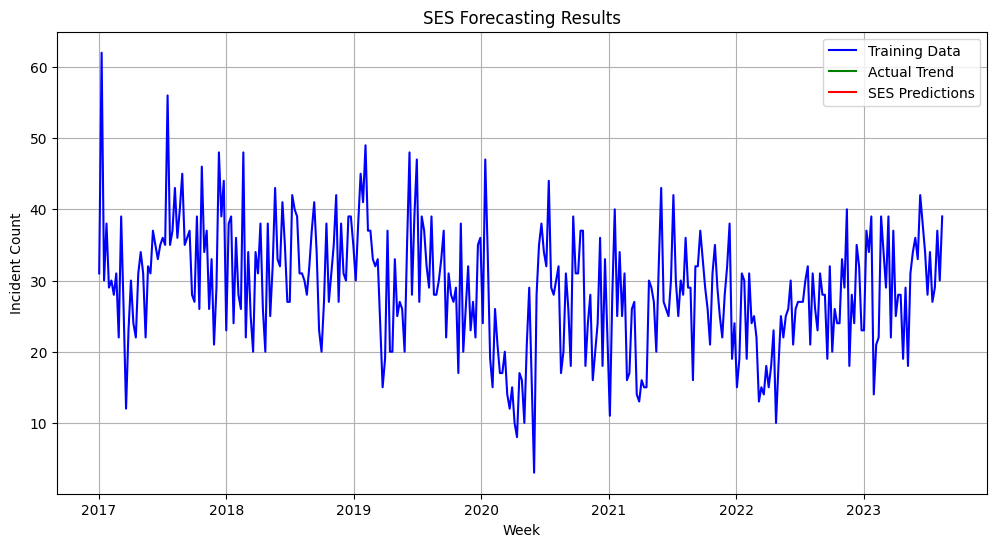

In [161]:
ses_run_and_plot(weekly_df, 1)

In [155]:
def arima_run_and_plot(df, test_size):
    train_data = df[:-test_size]
    test_data = df[-test_size:]
    
    model = ARIMA(train_data['incident_count'], order=(2, 1, 1))
    model_fit = model.fit()
    
    predictions = model_fit.forecast(steps=len(test_data))
    
    print(predictions)
    
    # Plot the training data
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['week'], train_data['incident_count'], label='Training Data', color='blue')

    # Plot the test data (actual trend)
    plt.plot(test_data['week'], test_data['incident_count'], label='Actual Trend', color='green')

    # Plot the SES predictions
    plt.plot(test_data['week'], predictions, label='ARIMA Predictions', color='red')

    # Set labels and title
    plt.xlabel('Week')
    plt.ylabel('Incident Count')
    plt.legend()
    plt.title('SES Forecasting Results')

    # Show the plot
    plt.grid(True)
    plt.show()

In [ ]:
# accident distrib

345    31.060545
346    30.380386
Name: predicted_mean, dtype: float64


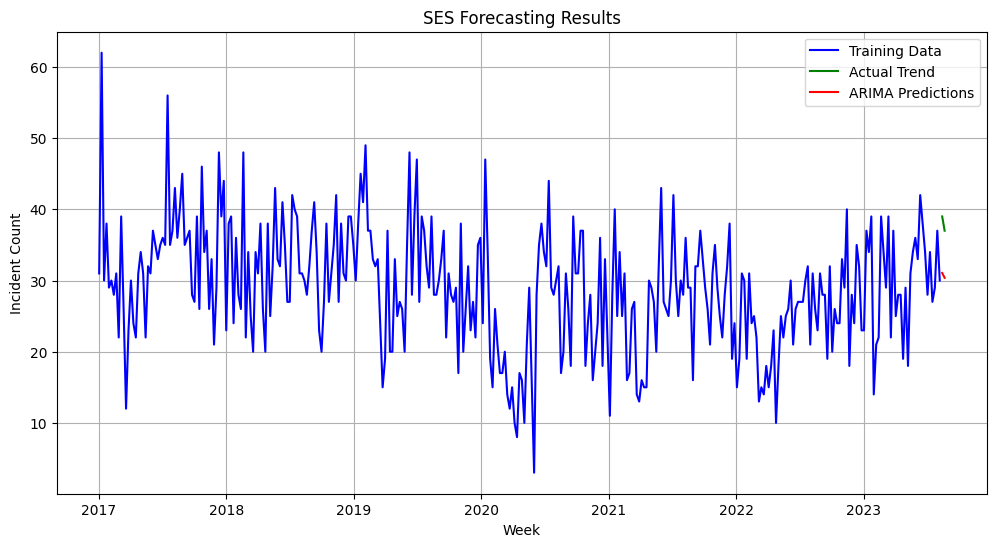

In [156]:
arima_run_and_plot(weekly_df, 2)

## EDA

In [162]:
accident_df = pd.read_sql("SELECT icr, incident_date FROM raw_accidents", db)

accident_df = accident_df.sort_values("incident_date").reset_index(drop=True)

accident_df["incident_date"] = pd.to_datetime(accident_df.incident_date, format="%Y-%m-%d")

In [163]:
accident_df

,icr,incident_date
0,17900008,2017-01-01 20:02:00
1,17900023,2017-01-02 12:07:00
2,17800016,2017-01-02 16:10:00
3,17800019,2017-01-02 16:55:00
4,17600041,2017-01-02 21:52:00
...,...,...
10062,23272074,2023-08-30 11:54:00
10063,23310929,2023-08-30 13:56:00
10064,23201998,2023-08-30 15:46:00
10065,23801385,2023-08-30 17:55:00


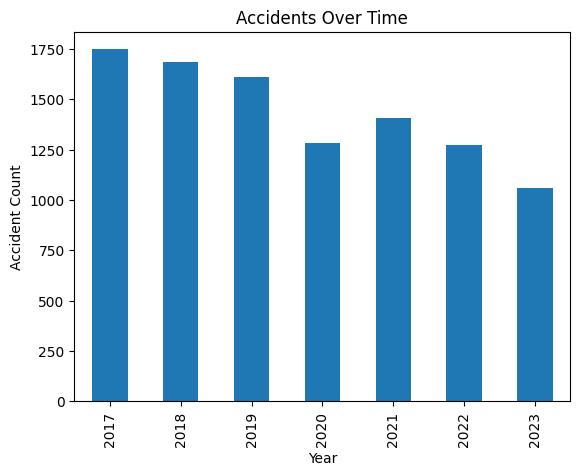

In [164]:
accident_df['year'] = accident_df['incident_date'].dt.year
yearly_accidents = accident_df.groupby('year').size()
yearly_accidents.plot(kind='bar', xlabel='Year', ylabel='Accident Count')
plt.title('Accidents Over Time')
plt.show()

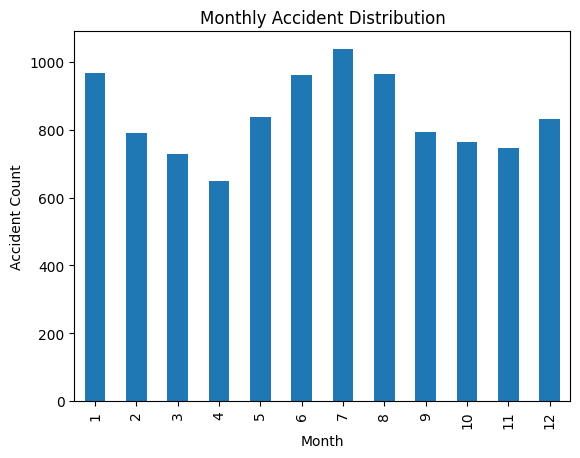

In [166]:
# Group accidents by month and plot the count
accident_df['month'] = accident_df['incident_date'].dt.month
monthly_accidents = accident_df.groupby('month').size()
monthly_accidents.plot(kind='bar', xlabel='Month', ylabel='Accident Count')
plt.title('Monthly Accident Distribution')
plt.show()

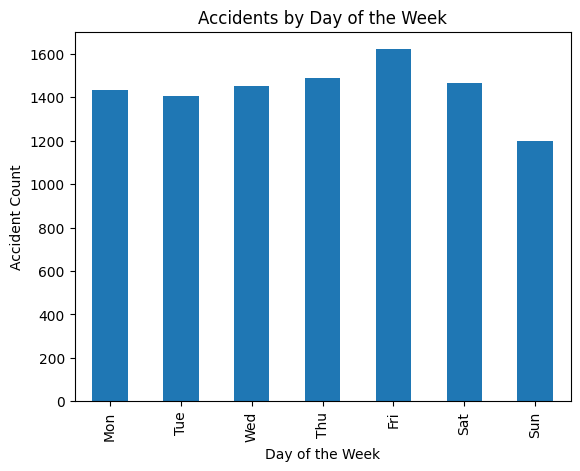

In [167]:
# Group accidents by day of the week and plot the count
accident_df['day_of_week'] = accident_df['incident_date'].dt.dayofweek
day_of_week_accidents = accident_df.groupby('day_of_week').size()
day_of_week_accidents.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_of_week_accidents.plot(kind='bar', xlabel='Day of the Week', ylabel='Accident Count')
plt.title('Accidents by Day of the Week')
plt.show()

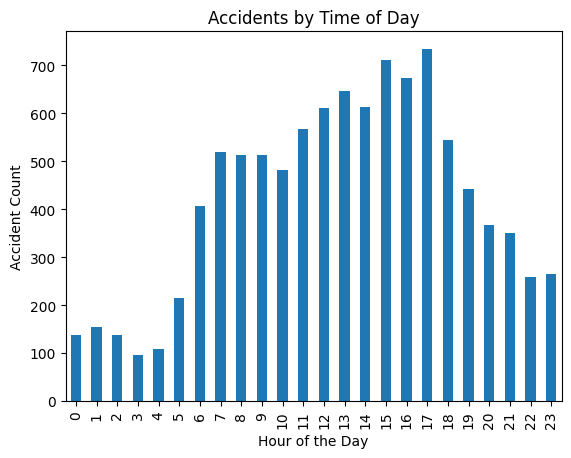

In [170]:
# Group accidents by hour and plot the count
accident_df['hour'] = accident_df['incident_date'].dt.hour
hourly_accidents = accident_df.groupby('hour').size()
hourly_accidents.plot(kind='bar', xlabel='Hour of the Day', ylabel='Accident Count')
plt.title('Accidents by Time of Day')
plt.xticks(range(24))  # Set the x-axis ticks to show all hours
plt.show()

In [ ]:
# LOOK AT HOW THIS CHANGES OVER TIME (PRE/POST COVID)

# MONTHLY TIME OF DAY

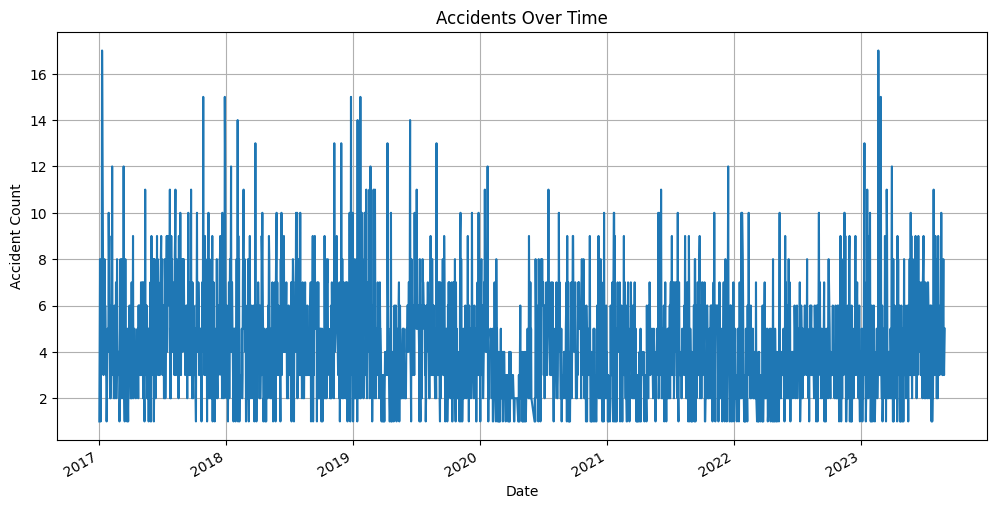

In [171]:
# Group accidents by date and plot the count
daily_accidents = accident_df.groupby(accident_df['incident_date'].dt.date).size()
daily_accidents.index = pd.to_datetime(daily_accidents.index)  # Convert the index to datetime
daily_accidents.plot(kind='line', xlabel='Date', ylabel='Accident Count', figsize=(12, 6))
plt.title('Accidents Over Time')
plt.grid(True)
plt.show()

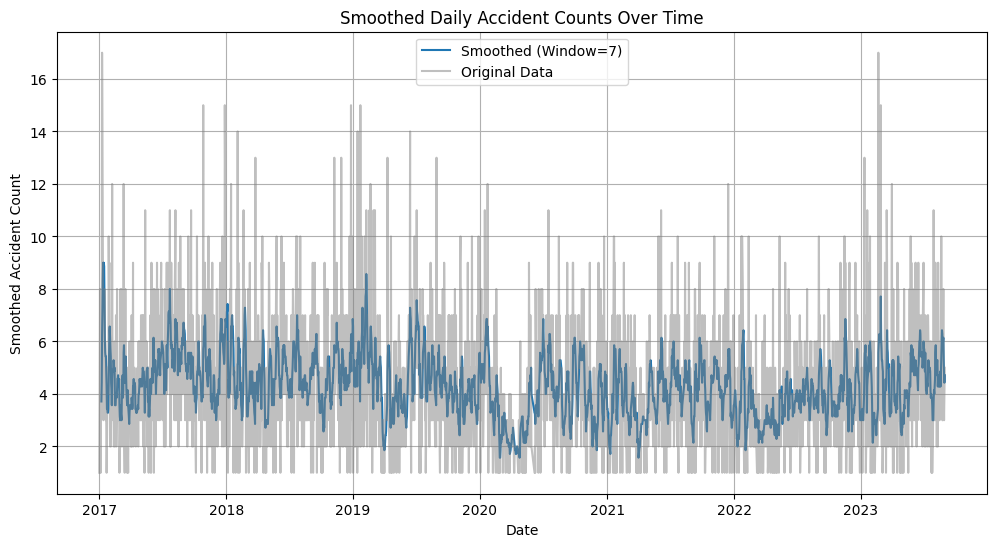

In [172]:
# Apply a moving average to smooth the data
window_size = 7  # You can adjust the window size as needed
smoothed_daily_accidents = daily_accidents.rolling(window=window_size).mean()

# Plot the smoothed data
plt.figure(figsize=(12, 6))
plt.plot(smoothed_daily_accidents.index, smoothed_daily_accidents, label=f'Smoothed (Window={window_size})')
plt.xlabel('Date')
plt.ylabel('Smoothed Accident Count')
plt.title('Smoothed Daily Accident Counts Over Time')
plt.grid(True)

# Optionally, you can also plot the original data for reference
plt.plot(daily_accidents.index, daily_accidents, alpha=0.5, label='Original Data', color='gray')

plt.legend()
plt.show()

In [ ]:
# DIFFERNT TEMPORAL SIGNATURE BY REGION

# TIME SERIES MODEL SPLIT FOR TEST/TRAIN - 50/50
# LOOK INTO 3 DAY TO GET MORE RECORDS

# FOUR YR TRAIN, 1 YR PREDICT

# LEAVE ONE OUT CV

# STORIES
    # Public Tool for safe driving and awareness
    # Covid TS Story?
    
    
# Spatial Regression w/ time lag

# COSINE SIMILIARY OF ACCIDENT DESCRIPTIONS

# LOOK AT ACCIDENT DESCRIPTIONS
# PATENT?

### Accident Distributions

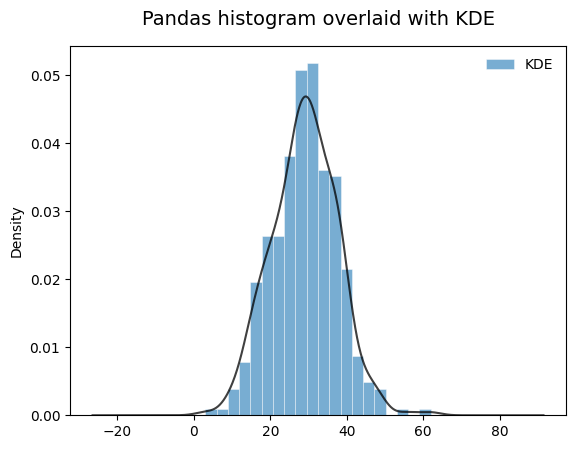

In [53]:
ax = weekly_df.plot.hist(bins=20, density=True, edgecolor='w', linewidth=0.5, alpha=0.6)
weekly_df.plot.density(color='k', alpha=0.75, ax=ax)

ax.legend(labels=['KDE'], frameon=False)
ax.set_title('Pandas histogram overlaid with KDE', fontsize=14, pad=15)

plt.show()